# Portfolio Project 1 - Indonesia AI - Reinaldo NLP4B

This is a sentiment analysis project using a sample of Twitter's data on Indonesian General Election 2019, initially carried out with @Roby Koeswojo, @Rijal Abdulhakim, @Satriavi Dananjaya, @Muhammad Yatsrib. This is the second, revised version of that project that I carried on my own, but I'm grateful for the opportunity to learn from them.

This dataset is a tweet dataset with Indonesia General Election 2019 provided by Indonesia AI.

In [1]:
import pandas as pd
import polars as pl

from urllib.parse import urlparse
import re
import random

import nltk
from nltk.util import ngrams
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier, DecisionTreeClassifier, MaxentClassifier, SklearnClassifier, ConditionalExponentialClassifier

from wordcloud import WordCloud
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [2]:
df = pl.read_csv('tweet.csv').to_pandas().reset_index(drop=True)
df = df[['sentimen', 'tweet']]
df.head(10)

sentimen                                              tweet
0  negatif  Kata @prabowo Indonesia tidak dihargai bangsa ...
1   netral  Batuan Langka, Tasbih Jokowi Hadiah dari Habib...
2   netral  Di era Jokowi, ekonomi Indonesia semakin baik....
3  positif  Bagi Sumatera Selatan, Asian Games berdampak p...
4  negatif  Negara kita ngutang buat bngun infrastruktur y...
5   netral  Yg bisikin pak jokowi, cm mikirin perputaran d...
6  positif  Masa tenang msih ngoceh aja..ttp jokowi harga ...
7  positif  #UASdifitnahKejiBalasDiTPS   kerjasa ekonomi b...
8   netral  Iya bener Aa, kita MANTAP kan pilihan ke Pemim...
9  negatif  Prabowo-Sandi Sepakat Tak Ambil Gaji karena Ne...

### Tweet Deconstruction

In [3]:
df['hashtags'] = df['tweet'].str.extractall(r'(#\w+)').unstack().apply(lambda x: ' '.join(x.dropna()), axis=1)
df['mentions'] = df['tweet'].str.extractall(r'(@\w+)').unstack().apply(lambda x: ' '.join(x.dropna()), axis=1)
df['negations'] = df['tweet'].str.extractall(r'(tapi|tetapi|namun|enggak|tidak|\sgak\s|tp|gak\s|\sga|\sga\s|tdk\s|\stdk\s)').unstack().apply(lambda x: ' '.join(x.dropna()), axis=1)
df['links'] = df['tweet'].str.extractall(r'(https?:\/\/\S+)').unstack().apply(lambda x: ' '.join(x.dropna()), axis=1)
df['emojis'] = df['tweet'].str.extractall(r'([^\x00-\x7F]+)').unstack().apply(lambda x: ' '.join(x.dropna()), axis=1)

df.head(10)

sentimen                                              tweet  \
0  negatif  Kata @prabowo Indonesia tidak dihargai bangsa ...   
1   netral  Batuan Langka, Tasbih Jokowi Hadiah dari Habib...   
2   netral  Di era Jokowi, ekonomi Indonesia semakin baik....   
3  positif  Bagi Sumatera Selatan, Asian Games berdampak p...   
4  negatif  Negara kita ngutang buat bngun infrastruktur y...   
5   netral  Yg bisikin pak jokowi, cm mikirin perputaran d...   
6  positif  Masa tenang msih ngoceh aja..ttp jokowi harga ...   
7  positif  #UASdifitnahKejiBalasDiTPS   kerjasa ekonomi b...   
8   netral  Iya bener Aa, kita MANTAP kan pilihan ke Pemim...   
9  negatif  Prabowo-Sandi Sepakat Tak Ambil Gaji karena Ne...   

                                            hashtags               mentions  \
0                                                NaN  @prabowo @rockygerung   
1                                                NaN                    NaN   
2  #01IndonesiaMaju #JokowiLagi #JokowiMenangTota...                    NaN   
3                                                NaN                    NaN   
4                                                NaN                    NaN   
5                                                NaN                    NaN   
6                                                NaN                    NaN   
7  #UASdifitnahKejiBalasDiTPS #UASdifitnahKejiBal...                    NaN   
8                                                NaN   @jokowi @SBYudhoyono   
9                                            #GoAceh                    NaN   

  negations                                              links  \
0  tidak tp  https://twitter.com/mediaindonesia/status/1117...   
1        tp                             http://dlvr.it/R2pvZVÂ   
2       NaN                                                NaN   
3       NaN                                                NaN   
4       NaN                                                NaN   
5        tp                                                NaN   
6        tp                                                NaN   
7       NaN                                                NaN   
8       NaN                                                NaN   
9        tp  https://www.goaceh.co/artikel/serbaserbi/2019/...   

            emojis  
0  ðŸ‘‡ ðŸ˜œ Â â€¦  
1               Â   
2              NaN  
3              NaN  
4              NaN  
5              NaN  
6              NaN  
7              NaN  
8    ðŸ˜‚ ðŸ™ðŸ‘  
9            Â â€¦

Some general checking...

In [4]:
def count_tweets(df, contains=[], not_contains=[]):
    query = ' & '.join([f'tweet.str.contains("{word}", case = False)' for word in contains] +
                       [f'~tweet.str.contains("{word}", case = False)' for word in not_contains])
    return df[['sentimen', 'tweet']].query(query).groupby('sentimen').count()

# Calculate the counts
a = df[['sentimen', 'tweet']].groupby(['sentimen']).count().sort_values('tweet', ascending=False)
b = count_tweets(df, contains=["jokowi"], not_contains=["prabowo"]).rename(columns={'tweet': 'jokowi & ~prabowo'})
c = count_tweets(df, contains=["prabowo"], not_contains=["jokowi"]).rename(columns={'tweet': 'prabowo & ~jokowi'})
d = count_tweets(df, contains=["jokowi", "prabowo"]).rename(columns={'tweet': 'jokowi & prabowo'})
e = count_tweets(df, not_contains=["jokowi", "prabowo"]).rename(columns={'tweet': '~prabowo & ~jokowi'})

# Concatenate the counts
f = pd.concat([a, b, c, d, e], axis=1)

# Calculate the totals
g = pd.DataFrame({'total': f.sum()}, index=f.columns).T

# Concatenate the counts and the totals
h = pd.concat([f, g], axis = 0)

h

tweet  jokowi & ~prabowo  prabowo & ~jokowi  jokowi & prabowo  \
positif    612                219                250                54   
netral     607                205                211                98   
negatif    596                162                168                71   
total     1815                586                629               223   

         ~prabowo & ~jokowi  
positif                  89  
netral                   93  
negatif                 195  
total                   377

It seems the dataset is quite balanced, although we can't really say that for jokowi and prabowo specific tweets. 

Tweet and links needs further cleaning, so let's do that.

In [5]:
pd.options.display.max_colwidth = 30

df2 = pd.DataFrame({'links': df['links']})
df2['links'].dropna(inplace=True)
df2['url_parts'] = df2['links'].apply(lambda x: urlparse(x) if isinstance(x, str) else None)

df2['scheme'] = df2['url_parts'].apply(lambda x: x.scheme if x else None)
df2['netloc'] = df2['url_parts'].apply(lambda x: x.netloc if x else None)
df2['path'] = df2['url_parts'].apply(lambda x: x.path if x else None)
df2['query'] = df2['url_parts'].apply(lambda x: x.query if x else None)
df2['fragment'] = df2['url_parts'].apply(lambda x: x.fragment if x else None)

df2.dropna().head(20)

links                      url_parts scheme  \
0   https://twitter.com/mediai...  (https, twitter.com, /medi...  https   
1          http://dlvr.it/R2pvZVÂ  (http, dlvr.it, /R2pvZVÂ, ...   http   
9   https://www.goaceh.co/arti...  (https, www.goaceh.co, /ar...  https   
10        https://bit.ly/2OgymxtÂ  (https, bit.ly, /2OgymxtÂ,...  https   
13  https://twitter.com/tag_nu...  (https, twitter.com, /tag_...  https   
20  https://twitter.com/sandiu...  (https, twitter.com, /sand...  https   
21  https://m.detik.com/news/b...  (https, m.detik.com, /news...  https   
24  https://www.merdeka.com/ua...  (https, www.merdeka.com, /...  https   
26  https://kumparan.com/berit...  (https, kumparan.com, /ber...  https   
32  https://twitter.com/AkunTo...  (https, twitter.com, /Akun...  https   
33  https://twitter.com/tag_nu...  (https, twitter.com, /tag_...  https   
34  https://apahabar.com/2019/...  (https, apahabar.com, /201...  https   
36  https://youtu.be/rMQzSqN-U3cÂ  (https, youtu.be, /rMQzSqN...  https   
38  https://nasional.kompas.co...  (https, nasional.kompas.co...  https   
39  https://www.youtube.com/wa...  (https, www.youtube.com, /...  https   
42  http://setkab.go.id/sepert...  (http, setkab.go.id, /sepe...   http   
43                  https://bit.l         (https, bit.l, , , , )  https   
44  http://mediaindonesia.com/...  (http, mediaindonesia.com,...   http   
49  https://nasional.kompas.co...  (https, nasional.kompas.co...  https   
51  http://metrobali.com/presi...  (http, metrobali.com, /pre...   http   

                 netloc                           path  \
0           twitter.com  /mediaindonesia/status/111...   
1               dlvr.it                       /R2pvZVÂ   
9         www.goaceh.co  /artikel/serbaserbi/2019/0...   
10               bit.ly                      /2OgymxtÂ   
13          twitter.com  /tag_nusantara/status/1061...   
20          twitter.com  /sandiuno/status/111710169...   
21          m.detik.com  /news/berita/d-4509616/jik...   
24      www.merdeka.com  /uang/harapan-dan-prediksi...   
26         kumparan.com  /beritajatim/kein-ada-18-k...   
32          twitter.com  /AkunTofa/status/111752874...   
33          twitter.com  /tag_nusantara/status/1061...   
34         apahabar.com  /2019/04/presiden-jokowi-d...   
36             youtu.be                  /rMQzSqN-U3cÂ   
38  nasional.kompas.com  /read/2018/09/24/22563621/...   
39      www.youtube.com                         /watch   
42         setkab.go.id  /seperti-game-of-throne-pr...   
43                bit.l                                  
44   mediaindonesia.com  /read/detail/229640-jokowi...   
49  nasional.kompas.com  /read/2018/09/24/22563621/...   
51        metrobali.com  /presiden-jokowi-dan-raja-...   

                            query             fragment  
0                           s=21Â                       
1                                                       
9   utm_source=dlvr.it&utm_med...                       
10                                                      
13                                                      
20                                                      
21  utm_content=detikcom&utm_t...  Echobox=1555171378Â  
24                                                      
26                                                      
32                                                      
33                                                      
34                                                      
36                                                      
38                                                      
39                 v=p8qVUqCF9ioÂ                       
42                                                      
43                                                      
44                                                      
49                                                      
51

In [6]:
replace = ['www', 'm', 'com', 'go', 'id', 'co', 'blogspot', 'id', 'net', 'org', 'co', 'amp', 'nasional', 'makassar', 'pemilu', 'info', 'share', 'jateng', 'news', 'pilpres', 'ekonomi', 'bisnis', 'ekbis', 'aceh', 'finance', 'sains', 'manado', 'politik', 'jabar', 'money', ]
rep = '|'.join(replace)

replace_dict = {
    'goo.gl': 'Google',
    'kom.ps': 'Kompas',
    'youtu.be': 'Youtube',
    'twitter.com': 'Twitter',
    'PILPRES.idÂ https:   ': 'Pilpres.id',
    'Bisnis.comÂ http:': 'Bisnis.com',
    'tmblr.co': 'Tumblr',
    'today.line.me': 'Line Today',
    '.comÂ http:': '',
    '.coÂ https:': '',
    '.tpÂ': ''
}

df2['netloc'] = df2['netloc'].replace(replace_dict, regex=True)
df2['netloc'] = df2['netloc'].apply(lambda x: '.'.join([i for i in str(x).split('.') if i not in replace]) if x else None)
df2['netloc'] = df2['netloc'].apply(lambda x: "Link Shortener" if "." in str(x) else str(x).capitalize())

a = df2[['netloc']].dropna().query('netloc.str.match("Twitter")').index #This will come in handy...

df2['netloc'].dropna().head(10)

0           Twitter
1    Link Shortener
2              None
3              None
4              None
5              None
6              None
7              None
8              None
9            Goaceh
Name: netloc, dtype: object

In [7]:
df2['path'] = df2['path'].drop(df2.index.difference(a)) #drop everything except for a; See a above
df2['path'] = df2['path'].str.split('/').str[1]
df2['path'] = df2['path'].str.capitalize()
df2['path'].dropna().head(10)

#In short, I take the indices of "path" where "netloc" contains "Twitter", and the first part of the link (the part after twitter.com/) is always a user handle.

0       Mediaindonesia
13       Tag_nusantara
20            Sandiuno
32            Akuntofa
33       Tag_nusantara
63     Tagar_nusantara
69     Tagar_nusantara
103      Tag_nusantara
124         Dhikabebeh
144            Rmol_id
Name: path, dtype: object

In [8]:
#Then, I put it back to the initial dataframe, and concat those "Twitter.com" with user handle.
df = df.drop(columns=['links'], axis = 1)
df['link'] = df2['netloc']
df['link'].loc[a] = df2['netloc'] + ' - ' + df2['path']
df['link'].dropna().head(10)

C:\Users\reina\AppData\Local\Temp\ipykernel_17172\2648326801.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['link'].loc[a] = df2['netloc'] + ' - ' + df2['path']


0    Twitter - Mediaindonesia
1              Link Shortener
2                        None
3                        None
4                        None
5                        None
6                        None
7                        None
8                        None
9                      Goaceh
Name: link, dtype: object

Before moving on, let's identify those news channel for later use.

In [9]:
news = ['kompas', 'detik', 'tribunnews', 'liputan6', 'viva', 'okezone', 'sindonews', 'suara', 'merdeka', 'republika', 'antaranews', 'tempo', 'kumparan', 'cnn', 'bbc', 'metro', 'wartaekonomi', 'jawapos', 'voaindonesia', 'cnbcindonesia', 'mediaindonesia', 'inews', 'rri', 'solopos']

df['newschannel'] = df['link'].apply(lambda x: 'News' if any(i in str(x).lower() for i in news) else 'Others')

df.query('newschannel == "News"').head(10)

sentimen                          tweet                       hashtags  \
0   negatif  Kata @prabowo Indonesia ti...                            NaN   
21  negatif  Jika Terpilih, Prabowo-San...                       #Echobox   
24  positif  #PilihOrangBaik #PilihJela...  #PilihOrangBaik #PilihJela...   
26  positif  #PilihOrangBaik #PilihJela...  #PilihOrangBaik #PilihJela...   
38  positif  #PilihOrangBaik #PilihYgJe...  #PilihOrangBaik #PilihYgJe...   
44   netral  Jokowi dan Raja Salman Sep...        #01OptimisIndonesiaMaju   
49  positif  #PilihOrangBaik #PilihJela...  #PilihOrangBaik #PilihJela...   
51   netral  Presiden Jokowi dan Raja S...                            NaN   
52   netral  gue kasih tau..Beberapa pe...  #PilihOrangBaikÂ #PilihJel...   
61  negatif  Alasan Prabowo-Sandi Tak T...                            NaN   

                 mentions negations            emojis  \
0   @prabowo @rockygerung  tidak tp   ðŸ‘‡ ðŸ˜œ Â â€¦   
21                    NaN        tp             Â â€¦   
24                @jokowi        tp         â€¦ Â â€¦   
26                    NaN  tidak tp         â€¦ Â â€¦   
38                @jokowi        tp             Â â€¦   
44                    NaN        tp             Â â€¦   
49                @jokowi        tp             Â â€¦   
51             @metrobali        tp             Â â€¦   
52                @jokowi        tp  Â  Â â€¦Â  Â  Â    
61          @kumparannews        tp             Â â€¦   

                        link newschannel  
0   Twitter - Mediaindonesia        News  
21                     Detik        News  
24                   Merdeka        News  
26                  Kumparan        News  
38                    Kompas        News  
44            Mediaindonesia        News  
49                    Kompas        News  
51                 Metrobali        News  
52                    Kompas        News  
61                  Kumparan        News

The next part is to clean stopwords using Louis Owen's Stoplist, with some additional words that I added. You can access this stoplist at https://github.com/louisowen6/NLP_bahasa_relinks/blob/master/combined_stop_words.txt. The other list, 'colloquial-indonesian-lexicon' is used to clean slang words, provided by my teammate @Roby Koeswojo.

In [10]:
slang_df = pd.read_csv("colloquial-indonesian-lexicon.csv")
slang_dict = slang_df.set_index('slang').to_dict(orient='dict')['formal']

df['tweet'] = df['tweet'].str.split().apply(lambda x: ' '.join([slang_dict[i] if i in slang_dict and i in x else i for i in x]))

with open('combined_stop_words.txt', 'r') as f:
    stop_words = f.read().splitlines()
    stopwords = [i for i in stop_words]

def clean_tweet(text):
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stopwords])
    text = re.sub(r'@[A-Za-z0-9]+', "[MENTION]", text)
    text = re.sub(r'#[A-Za-z0-9]+', "[MENTION]", text)
    text = re.sub('\\d+', '[NUM]', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'([^\x00-\x7F]+)', '', text)
    text = re.sub(r'[^\w\s\[\]]', '', text)
    text = re.sub('pictwittercom', '', text)
    return text

df['tweet'] = df['tweet'].apply(lambda x: clean_tweet(x))
df['tweet']

0       [MENTION] indonesia diharg...
1       batuan langka tasbih jokow...
2       era jokowi ekonomi indones...
3       sumatera selatan asian gam...
4       negara ngutang bangun infr...
                    ...              
1810    negarawan sejati bangga me...
1811    [NUM] hrs ceramah damai in...
1812    mari bangun bangsa menduku...
1813    bantu majukan perekonomian...
1814    [MENTION] mengubah pandang...
Name: tweet, Length: 1815, dtype: object

This leaves us with this dataframe to work with.

In [11]:
del df2
df

sentimen                          tweet                       hashtags  \
0     negatif  [MENTION] indonesia diharg...                            NaN   
1      netral  batuan langka tasbih jokow...                            NaN   
2      netral  era jokowi ekonomi indones...  #01IndonesiaMaju #JokowiLa...   
3     positif  sumatera selatan asian gam...                            NaN   
4     negatif  negara ngutang bangun infr...                            NaN   
...       ...                            ...                            ...   
1810   netral  negarawan sejati bangga me...             #2019GantiPresiden   
1811   netral  [NUM] hrs ceramah damai in...                   #PutihkanGBK   
1812   netral  mari bangun bangsa menduku...                            NaN   
1813   netral  bantu majukan perekonomian...                            NaN   
1814   netral  [MENTION] mengubah pandang...            #MenyatuPutihJokowi   

                   mentions negations           emojis  \
0     @prabowo @rockygerung  tidak tp  ðŸ‘‡ ðŸ˜œ Â â€¦   
1                       NaN        tp               Â    
2                       NaN       NaN              NaN   
3                       NaN       NaN              NaN   
4                       NaN       NaN              NaN   
...                     ...       ...              ...   
1810                    NaN       NaN              NaN   
1811                    NaN       NaN              NaN   
1812                    NaN        tp            Â â€¦   
1813                    NaN        tp            Â â€¦   
1814                @jokowi       NaN              NaN   

                          link newschannel  
0     Twitter - Mediaindonesia        News  
1               Link Shortener      Others  
2                         None      Others  
3                         None      Others  
4                         None      Others  
...                        ...         ...  
1810                      None      Others  
1811                      None      Others  
1812     Twitter - Kaskusloker      Others  
1813       Twitter - Bknsquare      Others  
1814                      None      Others  

[1815 rows x 8 columns]

### Initial Analysis: Hashtags

Since this portfolio is Indonesia AI's Basic NLP Program (which means does not include transformers), I will use n-gram language model for Exploratory Data Analysis and RNN/Word Embedding for sentiment analysis.

In [12]:
i = pd.DataFrame(df[['sentimen', 'hashtags']].query('sentimen == "positif"')['hashtags'].str.findall(r'#\w+').explode().value_counts())

j = pd.DataFrame(df[['sentimen', 'hashtags']].query('sentimen == "netral"')['hashtags'].str.findall(r'#\w+').explode().value_counts())

k = pd.DataFrame(df[['sentimen', 'hashtags']].query('sentimen == "negatif"')['hashtags'].str.findall(r'#\w+').explode().value_counts())

l = pd.DataFrame(df['hashtags'].str.findall(r'#\w+').explode().value_counts())

pd.concat([i, j, k, l], axis = 1, keys = ['positif', 'netral', 'negatif', 'total']).fillna(0).astype(int).sort_values(('total', 'count'), ascending = False)

positif netral negatif total
                          count  count   count count
hashtags                                            
#PrabowoSalahkanSBY          20     35      35    90
#PilihOrangBaik              32     29       0    61
#PilihBajuPutih              29     31       0    60
#PilihJelasIslamnya          27     28       0    55
#JokowiMenangTotalDebat      24     23       8    55
...                         ...    ...     ...   ...
#DebatCapresKelima            0      1       0     1
#RakyatMerdeka                0      1       0     1
#BacaKoranRM                  0      1       0     1
#IndonesiaSATU                0      1       0     1
#jokowimediaoligarki          0      0       1     1

[302 rows x 4 columns]

That doesn't look convincing at all. #PrabowoSalahkanSBY is neutral-negative with a bit of positivity? #PilihOrangBaik is positive-neutral? #PilihJelasIslamnya and #PilihBajuPutih follows the same suit? This is somewhat nonsense at best, and might not give good indication for the machine learning model to decide whether a tweet is positive, neutral, or negative.

### Initial Analysis: Tweet

Those [NUM] and [MENTION] masks will get in the way for human viewing. Let's clean that up to analyze these tweets in qualitative way.

In [13]:
df['analyzetweet'] = df['tweet'].str.replace('[NUM]', '').str.replace('[MENTION]', '')
df['analyzetweet']

0        indonesia dihargai bangsa...
1       batuan langka tasbih jokow...
2       era jokowi ekonomi indones...
3       sumatera selatan asian gam...
4       negara ngutang bangun infr...
                    ...              
1810    negarawan sejati bangga me...
1811     hrs ceramah damai indones...
1812    mari bangun bangsa menduku...
1813    bantu majukan perekonomian...
1814     mengubah pandang ekonomi ...
Name: analyzetweet, Length: 1815, dtype: object

Next up, I'll use Frequency Distribution of Bigram and Trigram, grouped by sentiment.

In [14]:
freqdists = pl.DataFrame({'sentimen': df['sentimen'], 'tweet': df['analyzetweet']}).to_pandas()

positive_bigram = FreqDist(ngrams(freqdists.query('sentimen == "positif"')['tweet'].str.cat(sep=' ').split(), 2))
positive_trigram = FreqDist(ngrams(freqdists.query('sentimen == "positif"')['tweet'].str.cat(sep=' ').split(), 3))

neutral_bigram = FreqDist(ngrams(freqdists.query('sentimen == "netral"')['tweet'].str.cat(sep=' ').split(), 2))
neutral_trigram = FreqDist(ngrams(freqdists.query('sentimen == "netral"')['tweet'].str.cat(sep=' ').split(), 3))

negative_bigram = FreqDist(ngrams(freqdists.query('sentimen == "negatif"')['tweet'].str.cat(sep=' ').split(), 2))
negative_trigram = FreqDist(ngrams(freqdists.query('sentimen == "negatif"')['tweet'].str.cat(sep=' ').split(), 3))

bigram = pd.DataFrame({'positif': positive_bigram, 'netral': neutral_bigram, 'negatif': negative_bigram}).fillna(0).astype(int)
bigram['total'] = bigram.sum(axis=1)
bigram['ratio'] = bigram.div(len(bigram.index)).sum(axis=1)

trigram = pd.DataFrame({'positif': positive_trigram, 'netral': neutral_trigram, 'negatif': negative_trigram}).fillna(0).astype(int)
trigram['total'] = trigram.sum(axis=1)
trigram['ratio'] = trigram.div(len(bigram.index)).sum(axis=1)

bigram.sort_values('total', ascending = False) #handy Pandas MultiIndex!

positif  netral  negatif  total     ratio
prabowo     sandi              98      47       28    173  0.017175
ambil       gaji               38      59       25    122  0.012112
ekonomi     indonesia          34      50       32    116  0.011517
pertumbuhan ekonomi            23      30       24     77  0.007645
ekonomi     makro              27      19       30     76  0.007545
...                           ...     ...      ...    ...       ...
sektor      tenaga              1       0        0      1  0.000099
elemen      sektor              1       0        0      1  0.000099
seluruh     elemen              1       0        0      1  0.000099
diambil     seluruh             1       0        0      1  0.000099
suram       perekonomian        0       0        1      1  0.000099

[20145 rows x 5 columns]

In [15]:
trigram.sort_values('total', ascending = False)

positif  netral  negatif  total     ratio
tusuk        prabowo      sandi           15      10        9     34  0.003376
ekonomi      indonesia    salah           10       9       12     31  0.003078
janji        ambil        gaji             7      20        2     29  0.002879
presiden     wakil        presiden        17       6        4     27  0.002681
prabowosandi ambil        gaji             1      19        1     21  0.002085
...                                      ...     ...      ...    ...       ...
pemimpin     berani       melihat          1       0        0      1  0.000099
perubahan    pemimpin     berani           1       0        0      1  0.000099
butuh        perubahan    pemimpin         1       0        0      1  0.000099
indonesia    butuh        perubahan        1       0        0      1  0.000099
suram        perekonomian rakyat           0       0        1      1  0.000099

[23716 rows x 5 columns]

Visualization time! Note, the higher an n_gram is (z-axis) the more neutral it will be, while further shift to the right (y-axis in 3 dimension, and it is a rectangle rather than a square) indicates more positivity of that n-gram. X-axis (the "depth") denotates negativity of that particular n-gram.

In [16]:
#Bigram visualization
bigram['label'] = bigram.index

fig = px.scatter_3d(bigram, x='negatif', y='positif', z='netral', opacity=0.6, hover_data=['label'], title='Bigram Sentiment Analysis')

fig.update_layout(scene = dict(
                    xaxis_title='Negatif',
                    yaxis_title='Positif',
                    zaxis_title='Netral'))

fig.show()

In [17]:
#Trigram visualization
trigram['label'] = trigram.index

fig = px.scatter_3d(trigram, x='negatif', y='positif', z='netral', opacity=0.6, hover_data=['label'], title='Trigram Sentiment Analysis')

fig.update_layout(scene = dict(
                    xaxis_title='Negatif',
                    yaxis_title='Positif',
                    zaxis_title='Netral'))

fig.show()

Now, let's see the "topics" in respective sentiment, starting from those negative tweets.

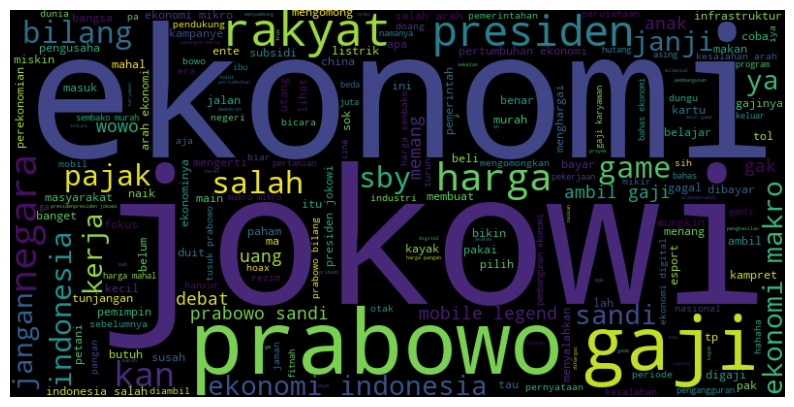

In [18]:
def wcloud(text):
    wc = WordCloud(width = 800, height = 400, max_words = 200).generate(text)
    plt.figure(figsize = (10, 10))
    plt.imshow(wc, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

wcloud(' '.join(df.query('sentimen == "negatif"')['analyzetweet']))

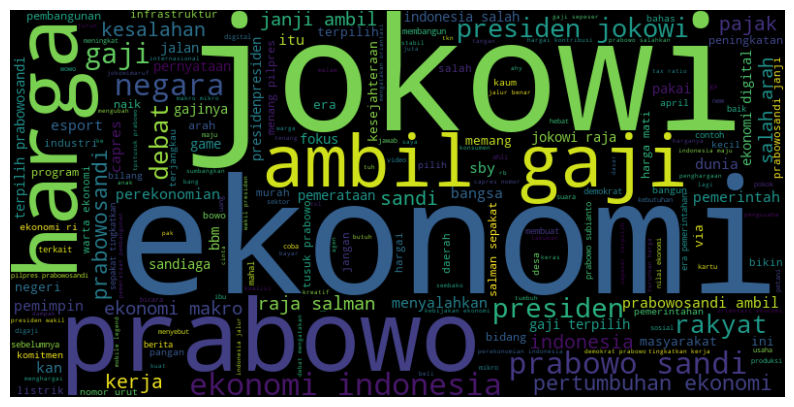

In [19]:
wcloud(' '.join(df.query('sentimen == "netral"')['analyzetweet']))

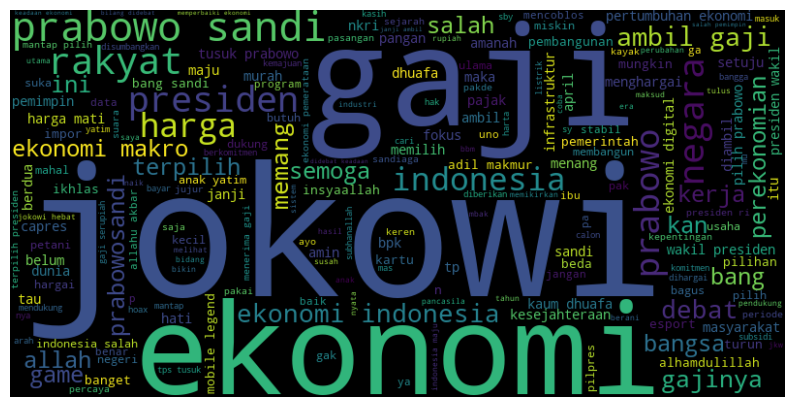

In [20]:
wcloud(' '.join(df.query('sentimen == "positif"')['analyzetweet']))

Economy. Economy everywhere. Now, let's dive deeper into each sentiment; First, I will check the correlation between news channel links and sentiment. In qualitative way, of course.

In [21]:
pd.options.display.max_colwidth = None
df[['sentimen', 'tweet', 'link', 'mentions', 'newschannel']].query('sentimen == "negatif" & newschannel == "News"')

sentimen  \
0     negatif   
21    negatif   
61    negatif   
231   negatif   
238   negatif   
334   negatif   
349   negatif   
550   negatif   
596   negatif   
634   negatif   
639   negatif   
828   negatif   
830   negatif   
974   negatif   
1079  negatif   
1090  negatif   
1100  negatif   
1265  negatif   
1371  negatif   
1418  negatif   
1585  negatif   
1732  negatif   
1771  negatif   

                                                                                                                                                                                                                                       tweet  \
0                                                                                                                                                     [MENTION] indonesia dihargai bangsa asing berita  hoax buatan penguasa kan [MENTION]     
21                                                                                                                 terpilih prabowosandiaga janji ambil gaji  orangorang superkaya mbok rendah hatilah jangan katakata berkonotasi angkuh      
61                                                                                                                                                                                     alasan prabowosandi terima gaji menang negara susah     
231                                 utang prabowo bwjibun bukan utng ln utang pribadinya puluhan triltun gaji diambilbusyeettt jngn[NUM] utang bebas dibayar jemarin[NUM] dipailitkan biar bayar pemerintah maka bwrambiai mengumbar janji     
238                                                    masalahnya [MENTION] janji ekonomi meroket eh nyungsep masalahnya link dibawah ingatkan [MENTION] janji bpk [MENTION] akui gagal penuhi janji cc [MENTION]_twit [MENTION] [MENTION]     
334                                                                                                                                                                          pernyataan [MENTION] [MENTION] ambil gaji beritakan [MENTION]     
349                                                                                                    prabowo terima gaji exit plan gaji karyawan pt kiani kertas [NUM] menerima gaji perhatian rakyat kecil karyawannya digaji munafikun     
550                                                                     prabowo bilang contoh cina buruhnya kerja [NUM] jam sehari libur minggu trus gaji buruhnya dibayar nasib [NUM][NUM] buruhnya gajinya terkatungkatung bertahuntahun     
596                                                                                                                      berita menyalahkan sby salah pembuat kesalahan perekonomian indonesia mungkin prabowo muka publik kesalahan konyol    
634                                                                                                  gak ambil gaji perusahaanya menguadai proyek[NUM]  kepadasobat[NUM] sekalian jangan golput ya tps pilih jokowi selamatkan bangsa kita     
639                                                                                                                                 maaf mengingatkan baoak menargetkan tumbahtumbuh pertumbuhan ekonomi [NUM] janji jokowi terwujud [NUM]     
828                                                                                                                bowo debat mengatakan orientasi ekonomi indonesia jalur benar meskipun itu menyalahkan jokowi pemimpin jokowi   [MENTION]   
830                                                                                                                                            bung bowo menyebut kesalahan arah ekonomi indonesia salah jokowi presidenpresiden   [MENTION]   
974                                                                                                                                   pertumbuhan ekonomi [MENTION] angka [NUM] belum menyaingi sby prabowo benar  impor ekspor  [MENTION]  

Echo chambers. You can really see how people quote several newschannel, comment on it, and present contrasting position against that newschannel. We might divulge how many echo chambers are there in this dataset, but might be inconclusive enough to generalize on the 'real' phenomenon.

In [22]:
df[['sentimen', 'tweet', 'link', 'mentions', 'newschannel']].query('sentimen == "netral" & newschannel == "News"')

sentimen  \
44     netral   
51     netral   
52     netral   
78     netral   
82     netral   
...       ...   
1518   netral   
1536   netral   
1586   netral   
1605   netral   
1637   netral   

                                                                                                                                                  tweet  \
44                                                                           jokowi raja salman sepakat tingkatkan kerja ekonomi   [MENTION] gudihikymw   
51                                                                         presiden jokowi raja salman sepakat tingkatkan kerja ekonomi   via [MENTION]   
52            kasih taubeberapa penghargaan dianugerahkan kepadanya bukti [MENTION] sosok pemimpin diakui integritasnya   [MENTION] [MENTION] [MENTION]   
78                                                                                      prabowo janjikan harga karet kelapa sawit bikin senyum petani     
82                          [MENTION] [MENTION] [MENTION] kepercayaan diberikan berpengalaman [MENTION] memiliki wakil berpengalaman dibidang ekonomi     
...                                                                                                                                                 ...   
1518  pemerintahan jokowi fokus pertumbuhan ekonomi berkeadilan  news   [MENTION] [MENTION] [MENTION] [MENTION] [MENTION] [MENTION] [MENTION] [MENTION]   
1536                                                                             ht [MENTION] arah ekonomi negara memang uud[NUM] protect lepas bebas     
1586                                        bung bowo menyebut kesalahan arah ekonomi indonesia salah jokowi presidenpresiden coblos [NUM]    [MENTION]   
1605                                                                                        pemerintahan jokowi fokus pertumbuhan ekonomi berkeadilan     
1637                                       akuntabilitas kenegarawan teruji menerimanya [MENTION] prabowo salahkan presiden jokowi perekonomian negara    

                           link    mentions newschannel  
44               Mediaindonesia         NaN        News  
51                    Metrobali  @metrobali        News  
52                       Kompas     @jokowi        News  
78                    Sindonews         NaN        News  
82                      Merdeka     @jokowi        News  
...                         ...         ...         ...  
1518                 Antaranews     @jokowi        News  
1536  Twitter - Officialinewstv    @prabowo        News  
1586               Cnnindonesia         NaN        News  
1605                 Antaranews         NaN        News  
1637                     Kompas         NaN        News  

[98 rows x 5 columns]

The echo chamber is also present in neutral, which shouldn't belong here really. That said, while some data are somewhat neutral, neutrality in these "y labels" of neutrality needs further scutiny.

In [23]:
df[['sentimen', 'tweet', 'link', 'mentions', 'newschannel']].query('sentimen == "positif" & newschannel == "News"')

sentimen  \
24    positif   
26    positif   
38    positif   
49    positif   
64    positif   
93    positif   
94    positif   
114   positif   
141   positif   
207   positif   
384   positif   
478   positif   
488   positif   
489   positif   
632   positif   
651   positif   
813   positif   
1133  positif   
1224  positif   
1325  positif   
1460  positif   
1471  positif   
1660  positif   
1803  positif   

                                                                                                                                                                    tweet  \
24                        [MENTION] [MENTION] [MENTION] kepercayaan diberikan berpengalaman [MENTION] memiliki wakil berpengalaman dibidang ekonomi coblos yuk [NUM] ya     
26                                  [MENTION] [MENTION] [MENTION] keberhasilan dibidang infrastruktur jokowi berhasil memperbaiki ekonomi indonesia coblos yuk [NUM] ya     
38                                                [MENTION] [MENTION] [MENTION] penghargaan dianugerahkan kepadanya bukti [MENTION] sosok pemimpin diakui integritasnya     
49                                                [MENTION] [MENTION] [MENTION] penghargaan dianugerahkan kepadanya bukti [MENTION] sosok pemimpin diakui integritasnya     
64                                                                                                                  janji ambil gaji menang pilpres prabowo bukti tulus     
93                                                      [MENTION] [MENTION] [MENTION] keberhasilan dibidang infrastruktur jokowi berhasil memperbaiki ekonomi indonesia     
94                 jokowimaruf pemimpin indonesia [MENTION] [MENTION] [MENTION] penghargaan dianugerahkan kepadanya bukti [MENTION] sosok pemimpin diakui integritasnya     
114                    jokowikma pemimpin optimis [MENTION] [MENTION] [MENTION] penghargaan dianugerahkan kepadanya bukti [MENTION] sosok pemimpin diakui integritasnya     
141                                                presiden jokowi raja salman bin abdulaziz alsaud melakukan pertemuan bilateral keduanya sepakat kerja bidang ekonomi     
207                                mengembangkan ekonomi syariah diamanatkan maruf amin aliansi kiai kampung madura akma menangkan jokowi [MENTION] [MENTION] [MENTION]     
384                                                                                                      ditanyakan jokowi ekonomi digital alhamdullilah prabowo mantap     
478                                                                                  semoga jokowers membaca hidayah allah swt terpilih prabowosandiaga janji ambil gaji    
488                                    tgb menilai jokowi debat jokowi kuasai bagaimama membangun ekonomi kreatif [MENTION] [MENTION] [MENTION] [MENTION]_byo [MENTION]     
489                                                                                                       [MENTION] ditanya kritik prabowo ahy hargai pemimpin pendahulu    
632                                                                                                         prabowo sandi gaji [NUM] sumbangkan kaum duafa fakir miskin     
651                                                                  debat penutupan [MENTION] [MENTION] komitemen ambil gaji serupiah amanah ini [MENTION] [MENTION]       
813               debat jokowi menasihati paslon [NUM] pengelolaan ekonomi makro membuktikan jokowi menguasai ekonomi [MENTION] [MENTION] [MENTION] [MENTION] [MENTION]     
1133                                    prabowosandi ambil gajinya sepersen terpilih gaji terima berikan kaum yatim dhuafa sungguh mulia hati pemimpin ini allahu akbar     
1224  rangkuman [MENTION] semalam   seru juga jokowi lelah orasi sore kyai afk prabowo perubahan bang sandi gile menggebugebu ilmu ekonomi nya nice fight from both sides   
1325                                                             [MENTION] [MENTION] paksiapapun presidengaji ambil saj

The same echo chambers as negative.

Next, let's see from 'other' sources.

In [24]:
df[['sentimen', 'tweet', 'link', 'mentions', 'newschannel']].query('sentimen == "negatif" & newschannel == "Others"')

sentimen  \
4     negatif   
9     negatif   
12    negatif   
22    negatif   
25    negatif   
...       ...   
1791  negatif   
1792  negatif   
1793  negatif   
1794  negatif   
1805  negatif   

                                                                                                                                                                                                  tweet  \
4                                   negara ngutang bangun infrastruktur dipakai masyarakat masyarakatnya ngeluh negara ngutang negara ngutang utang dibayar negara penghasilan penghasilan negara pajak   
9                                                                                                                                            prabowosandi sepakat ambil gaji negara susah     [MENTION]   
12                                                                                                     gak nginti [MENTION] [MENTION]_abdillahtoha ngacaaa gak mengajari sandi ekonomi dibanding jokowi   
22    [MENTION] menghargai relawan puasa tirakatan munajad semalam suntuk berdoa kemenangan [NUM]  mhn dibalas tweet kontribusi ngopi rokok tirakatmujahadah jika maka [NUM] gagalayo tirakat munajadin   
25                                                                                               ummat islam waras cerdas senang beramalcoblos prabowo andil dlm beramal  gaji tdk diambil tp untk amal   
...                                                                                                                                                                                                 ...   
1791                                                                                                                                                        harga komoditi anjlok jokowi solusi ngasal    
1792                                                                                                           kepemimpinan zonk dpr super nyinyir menghina puteri bangsa indonesia dihargai mata dunia   
1793                                            prabowo presiden dinasti cendana bangun kekuasaan orde baru gitulah lebih[NUM] harta harto swiss kena amnesti pajak perundingan ulang prabowo presiden    
1794                                                                                  jokowi is nothing gives nothing perekonomian kesejahteraan rakya indonesia perekonomian china he gives everything   
1805                                                                                                                                        berkat jokowi suram perekonomian rakyat indonesia [MENTION]   

                link                         mentions newschannel  
4               None                              NaN      Others  
9             Goaceh                              NaN      Others  
12              None  @yunartowijaya @AT_AbdillahToha      Others  
22              None                         @prabowo      Others  
25              None                              NaN      Others  
...              ...                              ...         ...  
1791  Link Shortener                              NaN      Others  
1792            None                              NaN      Others  
1793            None                              NaN      Others  
1794            None                              NaN      Others  
1805            None                              NaN      Others  

[573 rows x 5 columns]

Same thing, different rows.

In [25]:
df[['sentimen', 'tweet', 'link', 'mentions', 'newschannel']].query('sentimen == "netral" & newschannel == "Others"')

sentimen  \
1      netral   
2      netral   
5      netral   
8      netral   
14     netral   
...       ...   
1810   netral   
1811   netral   
1812   netral   
1813   netral   
1814   netral   

                                                                                                                                                                                                     tweet  \
1                                                                                                                                           batuan langka tasbih jokowi hadiah habib luthfi seharga mercy    
2                                                                                                                           era jokowi ekonomi indonesia baik [MENTION] [MENTION] [MENTION] w[NUM]ythnxstp   
5     bisikin jokowi memikirkan perputaran duit golongan tertentu esports kecil penentu pertumbuhan perekonomian indonesia fundamental dikatakan prabowo bahasa sederhana mrpkan aspek fundamental ekonomi   
8        iya benar aa mantap kan pilihan pemimpin solusi [MENTION] menyalahkan pemimpin [MENTION] dismash mas bowo koalisi mengantam teman koalisi  pulang pilih pemimpin rajin ibadah wajib ngaji jumatan   
14                                                                                                                                                       nge bahas ekonomi angka[NUM] bahas mobil lejen aj   
...                                                                                                                                                                                                    ...   
1810                                                                                                                             negarawan sejati bangga mengedepankan harga bangsanya berdaulat [MENTION]   
1811                                                                                                                              [NUM] hrs ceramah damai indonesiaku [NUM] perekonomian membaik [MENTION]   
1812                                                                                                                                   mari bangun bangsa mendukung perekonomian negara jokowi ayo kerja     
1813                                                                                                                                                        bantu majukan perekonomian bangsa jokowi yuk     
1814                                                                                                               [MENTION] mengubah pandang ekonomi kini terhubung indonesia produktif efisien [MENTION]   

                       link              mentions newschannel  
1            Link Shortener                   NaN      Others  
2                      None                   NaN      Others  
5                      None                   NaN      Others  
8                      None  @jokowi @SBYudhoyono      Others  
14                     None                   NaN      Others  
...                     ...                   ...         ...  
1810                   None                   NaN      Others  
1811                   None                   NaN      Others  
1812  Twitter - Kaskusloker                   NaN      Others  
1813    Twitter - Bknsquare                   NaN      Others  
1814                   None               @jokowi      Others  

[509 rows x 5 columns]

In [26]:
df[['sentimen', 'tweet', 'link', 'mentions', 'newschannel']].query('sentimen == "positif" & newschannel == "Others"')

sentimen  \
3     positif   
6     positif   
7     positif   
10    positif   
11    positif   
...       ...   
1754  positif   
1757  positif   
1760  positif   
1767  positif   
1795  positif   

                                                                                                                                                                                                                                         tweet  \
3                                                                                                                            sumatera selatan asian games berdampak ekonomi diprediksi mencapai [NUM][NUM] triliun indonesia maju jokowi hebat   
6                                                                                                                                                                                                     tenang mengoceh ajattp jokowi harga mati   
7                                                                                                                                                   [MENTION] kerjasa ekonomi bilateral multilateral doakan tps dengarkan suara hati [MENTION]   
10                                                                                                        [MENTION] [MENTION] [MENTION] pilih pemimpin pencapaiannya nah [NUM] pencapaian ekonomi pemerintahan jokowi coblos [NUM] yuk kerja     
11                                                                                                calon presiden jokowi program kartu pra kerja insentif kurun tertentu gaji cumacuma masyarakat belum berpenghasilan [MENTION] nj[NUM]hhmiizv   
...                                                                                                                                                                                                                                        ...   
1754                                                                                                         alangkah baiknya [MENTION] [MENTION] gaji presiden wakil presiden tunjangan jabatannya endingnya pemberiannya besar pahala besar    
1757  bismillah dilihat hasil debat malam pasangan prabowo sandi konsen masyarakat diutamakan swasembada pangan harga bahan pokoklistrik bbm turun menciptakan [NUM] jt lapangan kerja insya allah mantap pilih [NUM] setuju rt broo [MENTION]   
1760                                                                                                                          performa penjelasan jokowi kh maruf amin capaian ekonomi pemerataan sabang merauke [MENTION] [MENTION] [MENTION]   
1767                                                                                                                                       wow ngambil gaji sedikitpun presiden yaallah semoga rejeki prabowo sandi dilimpahkan menerus aamiin   
1795                                                     keamanan negeri ini kemajuan ekonomi infrastruktur pendidikan birokrasimaritim lainnya berhasil mengarah kearah baik [MENTION] [NUM] periode [MENTION] [MENTION] [MENTION] wjbtinhykl   

                link            mentions newschannel  
3               None                 NaN      Others  
6               None                 NaN      Others  
7               None                 NaN      Others  
10    Link Shortener                 NaN      Others  
11              None                 NaN      Others  
...              ...                 ...         ...  
1754            None  @prabowo @sandiuno      Others  
1757            None                 NaN      Others  
1760            None                 NaN      Others  
1767            None                 NaN      Others  
1795            None             @jokowi      Others  

[588 rows x 5 columns]

I won't analyze these echo chambers for now, and will straight up prepare the test data for later use.

In [27]:
h

tweet  jokowi & ~prabowo  prabowo & ~jokowi  jokowi & prabowo  \
positif    612                219                250                54   
netral     607                205                211                98   
negatif    596                162                168                71   
total     1815                586                629               223   

         ~prabowo & ~jokowi  
positif                  89  
netral                   93  
negatif                 195  
total                   377

This is my sampling strategy: I'll assume that positif, netral, and negatif has equal number, since the three is almost perfectly equal. Hence, this number consists of:

10% of `jokowi & ~prabowo`, `prabowo & ~jokowi`, `jokowi & prabowo`, `~prabowo & ~jokowi`. Respectively: 

22, 25, 5, and 9 tweets, with `61` positif tweets in total.

20, 21, 10, and 9 tweets, with `60` netral tweets in total.

16, 17, 7, and 20 tweets, with `60` negatif tweets in total.

This means `181` tweets will be used as a test data.

As for "Ekonomi", I will try to weed out any "Ekonomi" tweets as many as I could, although it will be tough given how dominant it is on the wordcloud.

In [28]:
def get_indices(df, sentiment, contains=[], not_contains=[]):
    query = f'sentimen == "{sentiment}"'
    for word in contains:
        query += f' & tweet.str.contains("{word}", case = False)'
    for word in not_contains:
        query += f' & ~tweet.str.contains("{word}", case = False)'
    return df[['sentimen', 'tweet']].query(query).index

def get_sample_indices(df, sentiment, sample_size, contains=[], not_contains=[]):
    indices = get_indices(df, sentiment, contains, not_contains)
    return random.sample(list(indices), sample_size)

# Now you can use this function to get the sample indices
posjok_test_index = get_sample_indices(df, "positif", 22, contains=["jokowi"], not_contains=["prabowo"])
pospra_test_index = get_sample_indices(df, "positif", 25, contains=["prabowo"], not_contains=["jokowi"])
posduo_test_index = get_sample_indices(df, "positif", 5, contains=["jokowi", "prabowo"])
posnon_test_index = get_sample_indices(df, "positif", 9, not_contains=["jokowi", "prabowo"])

netjok_test_index = get_sample_indices(df, "netral", 20, contains=["jokowi"], not_contains=["prabowo"])
netpra_test_index = get_sample_indices(df, "netral", 21, contains=["prabowo"], not_contains=["jokowi"])
netduo_test_index = get_sample_indices(df, "netral", 10, contains=["jokowi", "prabowo"])
netnon_test_index = get_sample_indices(df, "netral", 9, not_contains=["jokowi", "prabowo"])

negjok_test_index = get_sample_indices(df, "negatif", 16, contains=["jokowi"], not_contains=["prabowo"])
negpra_test_index = get_sample_indices(df, "negatif", 17, contains=["prabowo"], not_contains=["jokowi"])
negduo_test_index = get_sample_indices(df, "negatif", 7, contains=["jokowi", "prabowo"])
negnon_test_index = get_sample_indices(df, "negatif", 20, not_contains=["jokowi", "prabowo"])

Then, The Train-Test Split in old pythonic way, without Sklearn or PyTorch's random_split.

In [29]:
#Note: I use the unmasked dataset to create train_data and test_data

test_data = df.loc[posjok_test_index + pospra_test_index + posduo_test_index + posnon_test_index + netjok_test_index + netpra_test_index + netduo_test_index + netnon_test_index + negjok_test_index + negpra_test_index + negduo_test_index + negnon_test_index]
test_data = df.drop(columns = ['hashtags', 'mentions', 'negations', 'link', 'emojis', 'newschannel', 'tweet'], axis = 1)

train_data = df.drop(index=test_data.index)
train_data = df.drop(columns = ['hashtags', 'mentions', 'negations', 'link', 'emojis', 'newschannel', 'tweet'], axis = 1)

test_data

sentimen  \
0     negatif   
1      netral   
2      netral   
3     positif   
4     negatif   
...       ...   
1810   netral   
1811   netral   
1812   netral   
1813   netral   
1814   netral   

                                                                                                                                                             analyzetweet  
0                                                                                                     indonesia dihargai bangsa asing berita  hoax buatan penguasa kan     
1                                                                                                          batuan langka tasbih jokowi hadiah habib luthfi seharga mercy   
2                                                                                                                          era jokowi ekonomi indonesia baik    wythnxstp  
3                                                                 sumatera selatan asian games berdampak ekonomi diprediksi mencapai  triliun indonesia maju jokowi hebat  
4     negara ngutang bangun infrastruktur dipakai masyarakat masyarakatnya ngeluh negara ngutang negara ngutang utang dibayar negara penghasilan penghasilan negara pajak  
...                                                                                                                                                                   ...  
1810                                                                                                     negarawan sejati bangga mengedepankan harga bangsanya berdaulat   
1811                                                                                                                 hrs ceramah damai indonesiaku  perekonomian membaik   
1812                                                                                                  mari bangun bangsa mendukung perekonomian negara jokowi ayo kerja    
1813                                                                                                                       bantu majukan perekonomian bangsa jokowi yuk    
1814                                                                                                 mengubah pandang ekonomi kini terhubung indonesia produktif efisien   

[1815 rows x 2 columns]

In [30]:
train_data

sentimen  \
0     negatif   
1      netral   
2      netral   
3     positif   
4     negatif   
...       ...   
1810   netral   
1811   netral   
1812   netral   
1813   netral   
1814   netral   

                                                                                                                                                             analyzetweet  
0                                                                                                     indonesia dihargai bangsa asing berita  hoax buatan penguasa kan     
1                                                                                                          batuan langka tasbih jokowi hadiah habib luthfi seharga mercy   
2                                                                                                                          era jokowi ekonomi indonesia baik    wythnxstp  
3                                                                 sumatera selatan asian games berdampak ekonomi diprediksi mencapai  triliun indonesia maju jokowi hebat  
4     negara ngutang bangun infrastruktur dipakai masyarakat masyarakatnya ngeluh negara ngutang negara ngutang utang dibayar negara penghasilan penghasilan negara pajak  
...                                                                                                                                                                   ...  
1810                                                                                                     negarawan sejati bangga mengedepankan harga bangsanya berdaulat   
1811                                                                                                                 hrs ceramah damai indonesiaku  perekonomian membaik   
1812                                                                                                  mari bangun bangsa mendukung perekonomian negara jokowi ayo kerja    
1813                                                                                                                       bantu majukan perekonomian bangsa jokowi yuk    
1814                                                                                                 mengubah pandang ekonomi kini terhubung indonesia produktif efisien   

[1815 rows x 2 columns]

### Word Embedding

Well.. the very problem is, a free, ready-to-use word embedding model for Bahasa Indonesia does not exist - at least to the best of my knowledge. Using an untrained word embedding is somewhat futile (because that embedding simply don't know any correlation between words, eliminating the famous "King - Man + Woman = Queen" computation analogy. See it here: https://www.technologyreview.com/2015/09/17/166211/king-man-woman-queen-the-marvelous-mathematics-of-computational-linguistics/)

(Remember: This is part of Indonesia AI's Natural Language Processing basic program, which excludes transformers).

In a sentence or two, Naive Bayes computes the conditional probability of things: What's the chance of B happening after A happened? What's the chance of someone, given a certain description, to be an accountant compared to a bank teller? I feel I'm incompetent enough to give you a comprehensive explanation of Bayes' theorem, so I'll give you my favourite-and-revered channel of mathematical explanation: **3 Blue 1 Brown**! https://www.youtube.com/watch?v=HZGCoVF3YvM&pp=ygUbMyBibHVlIDEgYnJvd24gbmFpdmUgYmF5ZXJz

For the these `nltk.classify` implementation, I'm following Mohamad Mahmood's explanation on `nltk.classify` package. See it here: https://blog.devgenius.io/text-classification-using-nltk-classifier-algorithms-acab7879c923

In [31]:
#Tokenize the train and test data
train_data['analyzetweet'] = train_data['analyzetweet'].apply(word_tokenize)
test_data['analyzetweet'] = test_data['analyzetweet'].apply(word_tokenize)

#Create features for train data
train = [(nltk.FreqDist(words), sentiment) for words, sentiment in zip(train_data['analyzetweet'], train_data['sentimen'])]
test = [(nltk.FreqDist(words), sentiment) for words, sentiment in zip(test_data['analyzetweet'], test_data['sentimen'])]
y_true = [sentiment for _, sentiment in test]

train[0]

(FreqDist({'indonesia': 1, 'dihargai': 1, 'bangsa': 1, 'asing': 1, 'berita': 1, 'hoax': 1, 'buatan': 1, 'penguasa': 1, 'kan': 1}),
 'negatif')

Let's see how this goes. Thanks, Mahmood!

In [32]:
# Naive Bayes Classifier
nb_classifier = NaiveBayesClassifier.train(train)
y_pred_nb = nb_classifier.classify_many([words for (words, sentiment) in test])
nb_accuracy = nltk.classify.accuracy(nb_classifier, test)
print("Naive Bayes Classifier Accuracy:", nb_accuracy)

# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier.train(train)
y_pred_dt = dt_classifier.classify_many([words for (words, sentiment) in test])
dt_accuracy = nltk.classify.accuracy(dt_classifier, test)
print("Decision Tree Classifier Accuracy:", dt_accuracy)

# Maximum Entropy Classifier
me_classifier = MaxentClassifier.train(train)
y_pred_me = me_classifier.classify_many([words for (words, sentiment) in test])
me_accuracy = nltk.classify.accuracy(me_classifier, test)
print("Maximum Entropy Classifier Accuracy:", me_accuracy)

# Support Vector Machine Classifier
svc_classifier = SklearnClassifier(SVC()).train(train)
y_pred_svc = svc_classifier.classify_many([words for (words, sentiment) in test])
svc_accuracy = nltk.classify.accuracy(svc_classifier, test)
print("Support Vector Machine Classifier Accuracy:", svc_accuracy)

# Conditional Exponential Classifier
ce_classifier = ConditionalExponentialClassifier.train(train)
y_pred_ce = ce_classifier.classify_many([words for (words, sentiment) in test])
ce_accuracy = nltk.classify.accuracy(ce_classifier, test)
print("Conditional Exponential Classifier Accuracy:", ce_accuracy)

# K-Nearest Neighbors Classifier
knn_classifier = SklearnClassifier(KNeighborsClassifier()).train(train)
y_pred_knn = knn_classifier.classify_many([words for (words, sentiment) in test])
knn_accuracy = nltk.classify.accuracy(knn_classifier, test)
print("K-Nearest Neighbors Classifier Accuracy:", knn_accuracy)

Naive Bayes Classifier Accuracy: 0.9168044077134986
Decision Tree Classifier Accuracy: 0.9129476584022038
  ==> Training (100 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.09861        0.337
             2          -0.77977        0.904
             3          -0.61876        0.927
             4          -0.51939        0.944
             5          -0.45089        0.956
             6          -0.40029        0.962
             7          -0.36111        0.966
             8          -0.32973        0.967
             9          -0.30394        0.969
            10          -0.28231        0.972
            11          -0.26389        0.972
            12          -0.24797        0.973
            13          -0.23408        0.975
            14          -0.22183        0.975
            15          -0.21094        0.977
            16          -0.20120        0.979
            17          -0.19241 

Accuracy: 

Naive Bayes Classifier Accuracy: 0.9168044077134986

Decision Tree Classifier Accuracy: 0.9129476584022038

Maximum Entropy Classifier Accuracy: 0.9933884297520661 (100 iterations of training. Log Likelihood: -0.05058)

Support Vector Machine Classifier Accuracy: 0.915702479338843

Conditional Exponential Classifier Accuracy: 0.9933884297520661 (100 iterations of training. Log Likelihood: -0.05058)

K-Nearest Neighbors Classifier Accuracy: 0.5730027548209367

Naive Bayes and K-Nearest Neighbors are blazing fast with cheap computation, which is an excellent alternative if you don't have any access to transformers, adequate GPU, Indonesian-specific language model (looking at you, spaCy!), or all of them. For others took longer, particularly Maximum Entropy and Conditional Exponential with 100 iterations of training, but both repaid that time with 0.993 accuracy. Let's check the confusion matrix now!

In [54]:
'''
#My Precious!
import pickle

pickle.dump(nb_classifier, open("nb_classifier.pkl", "wb"))
pickle.dump(dt_classifier, open("dt_classifier.pkl", "wb"))
pickle.dump(me_classifier, open("me_classifier.pkl", "wb"))
pickle.dump(svc_classifier, open("svc_classifier.pkl", "wb"))
pickle.dump(ce_classifier, open("ce_classifier.pkl", "wb"))
pickle.dump(knn_classifier, open("knn_classifier.pkl", "wb"))

pickle.dump(y_pred_nb, open('y_pred_nb.pkl', 'wb'))
pickle.dump(y_pred_dt, open('y_pred_dt.pkl', 'wb'))
pickle.dump(y_pred_me, open('y_pred_me.pkl', 'wb'))
pickle.dump(y_pred_svc, open('y_pred_svc.pkl', 'wb'))
pickle.dump(y_pred_ce, open('y_pred_ce.pkl', 'wb'))
pickle.dump(y_pred_knn, open('y_pred_knn.pkl', 'wb'))
'''

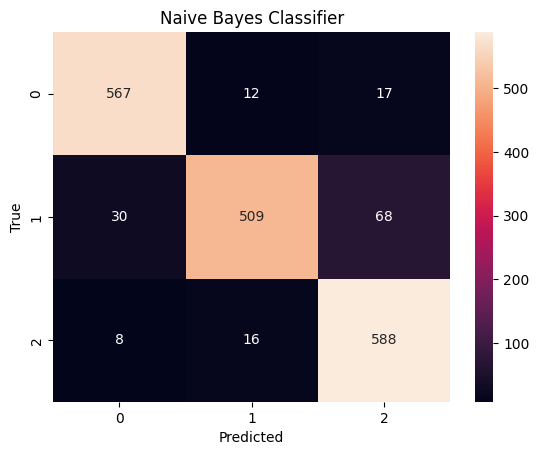

In [37]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(y_true, y_pred_nb, 'Naive Bayes Classifier')

In [46]:
[(true, pred) for true, pred in zip(y_true, y_pred_nb) if true != pred]

[('negatif', 'netral'),
 ('positif', 'netral'),
 ('netral', 'negatif'),
 ('positif', 'netral'),
 ('positif', 'netral'),
 ('netral', 'positif'),
 ('negatif', 'netral'),
 ('positif', 'netral'),
 ('negatif', 'positif'),
 ('netral', 'positif'),
 ('positif', 'netral'),
 ('netral', 'positif'),
 ('positif', 'netral'),
 ('negatif', 'netral'),
 ('negatif', 'netral'),
 ('netral', 'positif'),
 ('netral', 'positif'),
 ('netral', 'positif'),
 ('positif', 'netral'),
 ('negatif', 'netral'),
 ('netral', 'positif'),
 ('positif', 'netral'),
 ('netral', 'positif'),
 ('netral', 'positif'),
 ('netral', 'positif'),
 ('netral', 'negatif'),
 ('netral', 'negatif'),
 ('netral', 'positif'),
 ('netral', 'positif'),
 ('netral', 'positif'),
 ('netral', 'positif'),
 ('negatif', 'positif'),
 ('netral', 'positif'),
 ('netral', 'positif'),
 ('negatif', 'positif'),
 ('positif', 'negatif'),
 ('netral', 'positif'),
 ('netral', 'negatif'),
 ('netral', 'negatif'),
 ('netral', 'negatif'),
 ('netral', 'positif'),
 ('netral', 

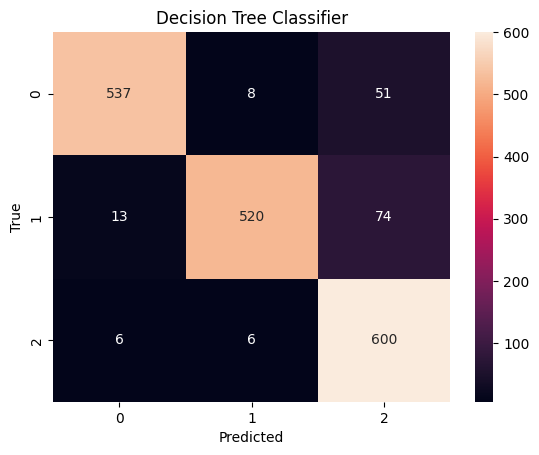

In [38]:
plot_confusion_matrix(y_true, y_pred_dt, 'Decision Tree Classifier')

In [48]:
[(true, pred) for true, pred in zip(y_true, y_pred_dt) if true != pred]

[('negatif', 'positif'),
 ('positif', 'negatif'),
 ('netral', 'negatif'),
 ('netral', 'positif'),
 ('netral', 'positif'),
 ('positif', 'netral'),
 ('netral', 'positif'),
 ('positif', 'netral'),
 ('netral', 'positif'),
 ('netral', 'negatif'),
 ('negatif', 'positif'),
 ('netral', 'positif'),
 ('netral', 'positif'),
 ('netral', 'positif'),
 ('netral', 'positif'),
 ('negatif', 'positif'),
 ('netral', 'negatif'),
 ('netral', 'positif'),
 ('negatif', 'positif'),
 ('negatif', 'positif'),
 ('netral', 'positif'),
 ('netral', 'positif'),
 ('netral', 'positif'),
 ('netral', 'positif'),
 ('positif', 'netral'),
 ('netral', 'positif'),
 ('negatif', 'positif'),
 ('netral', 'positif'),
 ('negatif', 'positif'),
 ('negatif', 'positif'),
 ('negatif', 'netral'),
 ('negatif', 'netral'),
 ('netral', 'positif'),
 ('netral', 'positif'),
 ('netral', 'negatif'),
 ('negatif', 'positif'),
 ('netral', 'positif'),
 ('netral', 'negatif'),
 ('netral', 'negatif'),
 ('netral', 'positif'),
 ('netral', 'positif'),
 ('neg

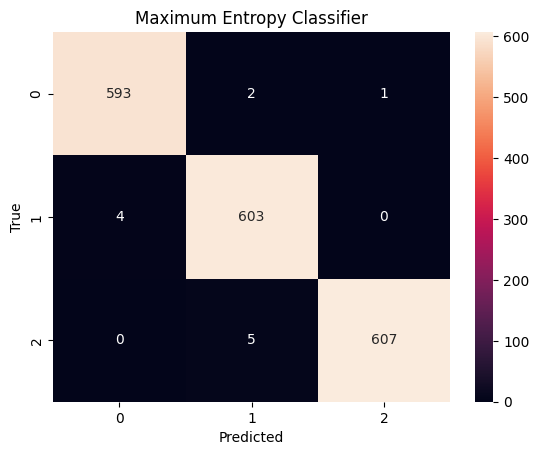

In [39]:
plot_confusion_matrix(y_true, y_pred_me, 'Maximum Entropy Classifier')

In [49]:
[(true, pred) for true, pred in zip(y_true, y_pred_me) if true != pred]

[('positif', 'netral'),
 ('positif', 'netral'),
 ('positif', 'netral'),
 ('netral', 'negatif'),
 ('positif', 'netral'),
 ('positif', 'netral'),
 ('negatif', 'netral'),
 ('negatif', 'positif'),
 ('negatif', 'netral'),
 ('netral', 'negatif'),
 ('netral', 'negatif'),
 ('netral', 'negatif')]

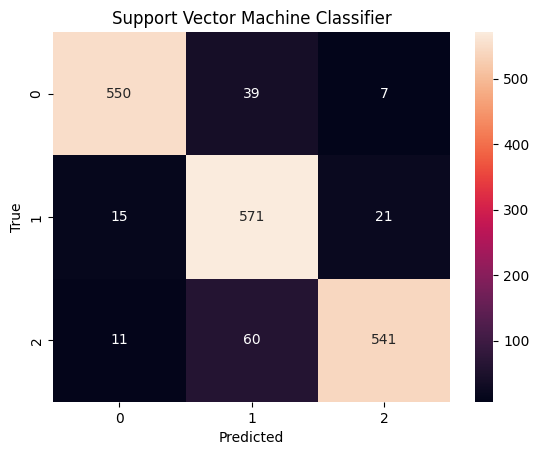

In [40]:
plot_confusion_matrix(y_true, y_pred_svc, 'Support Vector Machine Classifier')

In [50]:
[(true, pred) for true, pred in zip(y_true, y_pred_svc) if true != pred]

[('negatif', 'netral'),
 ('positif', 'netral'),
 ('positif', 'netral'),
 ('netral', 'positif'),
 ('positif', 'negatif'),
 ('positif', 'netral'),
 ('netral', 'positif'),
 ('negatif', 'netral'),
 ('positif', 'netral'),
 ('positif', 'netral'),
 ('negatif', 'netral'),
 ('positif', 'netral'),
 ('netral', 'positif'),
 ('positif', 'netral'),
 ('positif', 'negatif'),
 ('positif', 'netral'),
 ('negatif', 'netral'),
 ('negatif', 'netral'),
 ('netral', 'positif'),
 ('netral', 'positif'),
 ('positif', 'netral'),
 ('positif', 'netral'),
 ('netral', 'positif'),
 ('positif', 'netral'),
 ('negatif', 'netral'),
 ('netral', 'positif'),
 ('positif', 'netral'),
 ('netral', 'negatif'),
 ('netral', 'negatif'),
 ('negatif', 'netral'),
 ('positif', 'netral'),
 ('negatif', 'netral'),
 ('negatif', 'netral'),
 ('positif', 'netral'),
 ('positif', 'netral'),
 ('positif', 'netral'),
 ('netral', 'negatif'),
 ('negatif', 'netral'),
 ('negatif', 'netral'),
 ('netral', 'positif'),
 ('negatif', 'netral'),
 ('positif', '

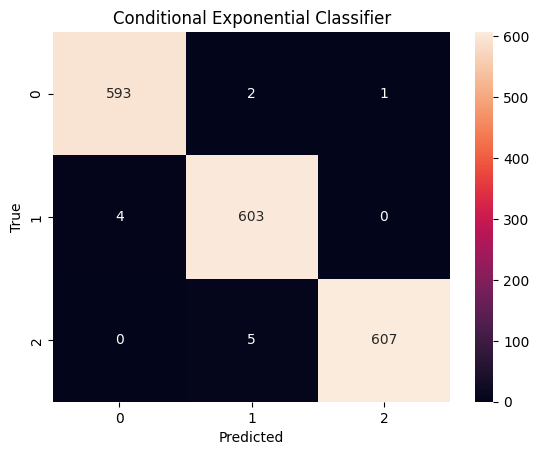

In [41]:
plot_confusion_matrix(y_true, y_pred_ce, 'Conditional Exponential Classifier')

In [51]:
[(true, pred) for true, pred in zip(y_true, y_pred_ce) if true != pred]

[('positif', 'netral'),
 ('positif', 'netral'),
 ('positif', 'netral'),
 ('netral', 'negatif'),
 ('positif', 'netral'),
 ('positif', 'netral'),
 ('negatif', 'netral'),
 ('negatif', 'positif'),
 ('negatif', 'netral'),
 ('netral', 'negatif'),
 ('netral', 'negatif'),
 ('netral', 'negatif')]

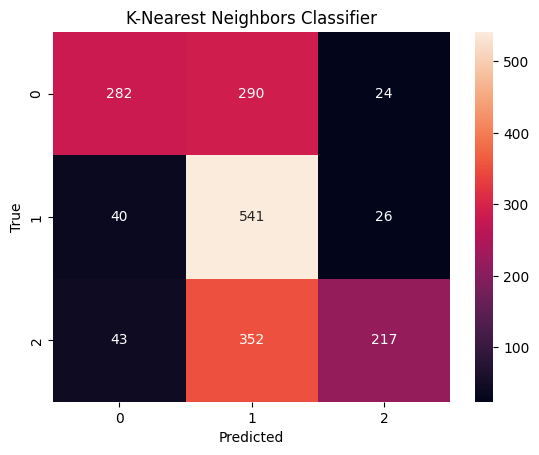

In [42]:
plot_confusion_matrix(y_true, y_pred_knn, 'K-Nearest Neighbors Classifier')

In [52]:
[(true, pred) for true, pred in zip(y_true, y_pred_knn) if true != pred]

[('negatif', 'netral'),
 ('positif', 'netral'),
 ('positif', 'netral'),
 ('negatif', 'netral'),
 ('positif', 'netral'),
 ('positif', 'netral'),
 ('negatif', 'netral'),
 ('positif', 'netral'),
 ('netral', 'negatif'),
 ('positif', 'netral'),
 ('positif', 'netral'),
 ('negatif', 'netral'),
 ('negatif', 'netral'),
 ('positif', 'netral'),
 ('negatif', 'netral'),
 ('negatif', 'netral'),
 ('negatif', 'netral'),
 ('positif', 'negatif'),
 ('positif', 'netral'),
 ('positif', 'netral'),
 ('negatif', 'netral'),
 ('netral', 'positif'),
 ('positif', 'netral'),
 ('negatif', 'netral'),
 ('positif', 'netral'),
 ('positif', 'netral'),
 ('negatif', 'netral'),
 ('positif', 'netral'),
 ('negatif', 'netral'),
 ('positif', 'netral'),
 ('positif', 'netral'),
 ('positif', 'netral'),
 ('negatif', 'netral'),
 ('negatif', 'netral'),
 ('positif', 'netral'),
 ('negatif', 'netral'),
 ('positif', 'netral'),
 ('negatif', 'netral'),
 ('positif', 'netral'),
 ('negatif', 'netral'),
 ('positif', 'netral'),
 ('negatif', 'n